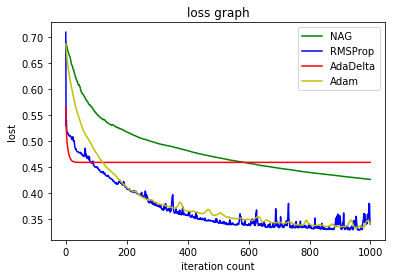

In [1]:
from sklearn import datasets, model_selection, linear_model
import numpy as np
import jupyter
import matplotlib.pyplot as plt
import math
import random

X_train, y_train = datasets.load_svmlight_file("a9atrain.txt")

# turn the csr_matrix into array for futher processing
x_ = np.array(X_train.toarray(), np.float32).reshape((-1, 123))
y_ = np.array(y_train, np.float32).reshape((-1, 1))

for i in range(y_.shape[0]):
	if y_[i,0] == -1.0 : y_[i,0] = 0.

X_ = np.hstack([x_, np.ones((x_.shape[0], 1))])


X_test, y_test = datasets.load_svmlight_file("a9atest.txt")

xt_ = np.array(X_test.toarray(), np.float32).reshape((-1, 122))
yt_ = np.array(y_test, np.float32).reshape((-1, 1))
for i in range(yt_.shape[0]):
	if yt_[i,0] == -1.0 : yt_[i,0] = 0.
# X_ = (x_;1) to fit the constent item

Xt_ = np.hstack([xt_, np.zeros((xt_.shape[0], 1)),np.ones((xt_.shape[0], 1))])


# hθ(X) = e^(Theta * X) / (1 + e^(Theta * X)) = 1 / (1 + e^(- Theta * X))
def h_theta(Xi, Theta):
	e_t = math.exp(Xi.dot(Theta.T))
	return e_t / (1 + e_t)

# L(θ) = - (1/m) ∑ (yi * log(hθ(Xi)) + (1 - yi) * log(1 - hθ(Xi)))
def compute_loss(X, y, Theta):
	m = y.shape[0]
	loss = 0.
	for i in range(m):
		loss +=  (y[i] * math.log(h_theta(X[i, :], Theta))) + ((1 - y[i]) * math.log(1 - h_theta(X[i,:], Theta)))
	loss /= - m
	return loss

# ∂L/∂θ = (1/m) ∑ (hθ(Xi) - yi) * Xi
def compute_gradient(X, y, Theta):
	m = y.shape[0]
	gradient = np.zeros(Theta.shape)
	for i in range(m):
		gradient += (h_theta(X[i, :], Theta) - y[i]) * (X[i, :])
	gradient /= m
	return gradient


def train_model_nag(X, y, Theta, learning_rate, gamma, iteration = 10000):
	test_loss_history = np.zeros((iteration, 1))
	v = np.zeros(Theta.shape)
	Theta_gradient = np.zeros(Theta.shape)
	for iter in range(iteration):
		index = random.randint(0, y.shape[0]-10)
		Theta = Theta - gamma * v
		v = gamma * v - learning_rate * compute_gradient(X[index:index+10,:], y[index:index+10], Theta)
		Theta = Theta + v
		test_loss_history[iter] = compute_loss(Xt_, yt_, Theta)[-1:]
	return test_loss_history, Theta


def train_model_rmsprop(X, y, Theta, learning_rate, gamma, epsilon, iteration = 10000):
	test_loss_history = np.zeros((iteration, 1))
	G_t = 0.
	Theta_gradient = np.zeros(Theta.shape)
	for iter in range(iteration):
		index = random.randint(0, y.shape[0]-10)
		Theta_gradient = compute_gradient(X[index:index+10,:], y[index:index+10], Theta)
		G_t = gamma * G_t + (1 - gamma) * Theta_gradient.dot(Theta_gradient.T)
		Theta = Theta - (learning_rate / np.square(G_t + epsilon)) * Theta_gradient
		test_loss_history[iter] = compute_loss(Xt_, yt_, Theta)[-1:]
	return test_loss_history, Theta


def train_model_adadelta(X, y, Theta, gamma, epsilon, iteration):
	test_loss_history = np.zeros((iteration, 1))
	Theta_gradient = np.zeros(Theta.shape)
	G_t = 0.
	delta_theta = np.zeros(Theta.shape)
	delta_t = 0.03
	for iter in range(iteration):
		# index = random.randint(0, y.shape[0]-10)
		Theta_gradient = compute_gradient(X, y, Theta)
		G_t = gamma * G_t + (1 - gamma) * Theta_gradient.dot(Theta_gradient.T)
		delta_theta = - (np.square(delta_t + epsilon) / np.square(G_t + epsilon)) * Theta_gradient
		Theta = Theta + delta_theta
		delta_t = gamma * delta_t + (1 - gamma) * (delta_theta.dot(delta_theta.T))
		test_loss_history[iter] = compute_loss(Xt_, yt_, Theta)[-1:]
	return test_loss_history, Theta

def train_model_adam(X, y, Theta, learning_rate, beta1, beta2, epsilon, iteration):
	test_loss_history = np.zeros((iteration, 1))
	Theta_gradient = np.zeros(Theta.shape)
	v_t = 0.
	m_t = np.zeros(Theta.shape)
	for iter in range(iteration):
		index = random.randint(0, y.shape[0]-10)
		Theta_gradient = compute_gradient(X[index:index+10,:], y[index:index+10], Theta)
		m_t = beta1 * m_t + (1 - beta1) * Theta_gradient
		v_t = beta2 * v_t + (1 - beta2) * Theta_gradient.dot(Theta_gradient.T)
		mt_estimate = m_t / (1 - pow(beta1, iter + 1))
		vt_estimate = v_t / (1 - pow(beta2, iter + 1))
		Theta = Theta - learning_rate * mt_estimate / (np.square(vt_estimate) + epsilon)
		test_loss_history[iter] = compute_loss(Xt_, yt_, Theta)[-1:]
	return test_loss_history, Theta

iteration = 1000

be1 = 0.9
be2 = 0.999
ep = 1e-8



t_nag = np.zeros((1, 124))
t_rmsprop = np.zeros((1, 124))
t_adadelta = np.zeros((1, 124))
t_adam = np.zeros((1, 124))

nag_loss_history, t_nag = train_model_nag(X_, y_, t_nag, 0.005, be1, iteration)
rmsprop_loss_history, t_rmsprop = train_model_rmsprop(X_, y_, t_rmsprop, 0.005, be1, ep, iteration)
adadelta_loss_history, t_adadelta = train_model_adadelta(X_, y_, t_adadelta, be1, ep, iteration)
adam_loss_history, t_adam = train_model_adam(X_, y_, t_adam, 0.005, be1, be2, ep, iteration)


plt.plot(nag_loss_history, 'g', label='NAG')
plt.plot(rmsprop_loss_history, 'b', label='RMSProp')
plt.plot(adadelta_loss_history, 'r', label='AdaDelta')
plt.plot(adam_loss_history, 'y', label='Adam')


plt.legend(loc='upper right')

plt.ylabel('lost');

plt.xlabel('iteration count')

plt.title('loss graph')

plt.show()